In [1]:
import geopandas as gp


def plot_geoframes(title: str, ground_truth: gp.GeoDataFrame, traces: dict[str, tuple[gp.GeoDataFrame, str]],
                   tiles: gp.GeoDataFrame = None, sign_point=None):
    ground_truth = ground_truth.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(10, 10))

    if tiles is not None:
        tiles = tiles.to_crs(epsg=3857)
        tiles.plot(
            ax=ax,
            facecolor="none",
            edgecolor="blue",
            linewidth=2,
            alpha=0.6,
            label="Geohash Tiles",
            zorder=3,
        )

    for label, trace in traces.items():
        gdf = trace[0].to_crs(epsg=3857)

        gdf.plot(
            ax=ax,
            markersize=20,
            label=label,
            zorder=4,
            cmap=trace[1],
            column="confidence",
            legend=True if len(traces) == 1 else False,
        )

    ground_truth.plot(
        ax=ax,
        color="red",
        marker="X",
        markersize=60,
        zorder=5,
        label="Road Sign (Ground Truth)"
    )

    # Center map on ground truth - we only look at a certain area of Rostock
    sign_point = ground_truth.geometry.iloc[0] if not sign_point else sign_point
    x_center, y_center = sign_point.x, sign_point.y
    radius = 100  # meters

    ax.set_xlim(x_center - radius, x_center + radius)
    ax.set_ylim(y_center - radius, y_center + radius)

    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_axis_off()
    ax.set_title(title)
    ax.legend()
    plt.show()

In [2]:
def validate_results(gdf_points: geopandas.GeoDataFrame, gdf_signs: geopandas.GeoDataFrame, method_name: str):
    # let's validate the results - epsg 25833 for Rostock
    validation_df = gdf_signs.to_crs(epsg=25833).merge(gdf_points.to_crs(epsg=25833), how="inner", on=["uuid"],
                                                       suffixes=("_sign", "_point"))
    validation_df["distance_to_sign"] = validation_df.geometry_sign.distance(validation_df.geometry_point)

    validation_df["method"] = method_name

    return validation_df[["method", "distance_to_sign", "is_centroid"]]

In [3]:
def plot_error_distributions(validation_df: pd.DataFrame):
    plt.figure(figsize=(10, 6))

    for method, grp in validation_df.groupby("method"):
        grp["distance_to_sign"].plot.kde(
            linewidth=2,
            label=method
        )

    plt.xlabel("Error distance [m]")
    plt.ylabel("Density")
    plt.title("Error Distribution Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()


In [18]:
def plot_aggregated_kpis(validation_df: pd.DataFrame, gdf_signs: gp.GeoDataFrame):
    import matplotlib.pyplot as plt

    kpi_df = validation_df.groupby("method").agg(
        mean_error=("distance_to_sign", "mean"),
        median_error=("distance_to_sign", "median"),
        min_error=("distance_to_sign", "min"),
        max_error=("distance_to_sign", "max"),
        num_centroids=("is_centroid", "sum")).reset_index()

    kpi_df["centroid_diff"] = (kpi_df["num_centroids"] - len(gdf_signs))
    kpi_df["centroid_diff_rel"] = ((kpi_df["num_centroids"] - len(gdf_signs)).abs() / len(gdf_signs)) * 100

    metrics = [
        ("mean_error", "Mean Error [m]"),
        ("median_error", "Median Error [m]"),
        ("max_error", "Max Error [m]"),
        ("min_error", "Min Error [m]"),
        ("centroid_diff", "Centroid Diff"),
        ("centroid_diff_rel", "Centroid Diff %")
    ]

    fig, axes = plt.subplots(
        1, len(metrics),
        figsize=(18, 5),
        sharex=True
    )

    for ax, (col, label) in zip(axes, metrics):
        ax.bar(kpi_df["method"], kpi_df[col])
        ax.set_title(label)
        ax.set_ylabel(label)
        ax.grid(axis="y")

        # annotate values
        for i, v in enumerate(kpi_df[col]):
            ax.text(i, v, f"{v:.2f}" if col != "centroid_diff" else f"{int(v)}",
                    ha="center", va="bottom", fontsize=9)

    fig.suptitle("Aggregated Validation KPIs per Method", fontsize=14)
    plt.tight_layout()
    plt.show()


In [5]:
import pandas as pd

input_df = pd.read_csv("input_data/verkehrszeichen.csv", delimiter=",")

In [6]:
from gps_emitter.road_sign_emitter import emit_traces

df = emit_traces(input_df)

# and a sample sign
sample_uuid = df["uuid"].iloc[0]
subset = df[df["uuid"] == sample_uuid]

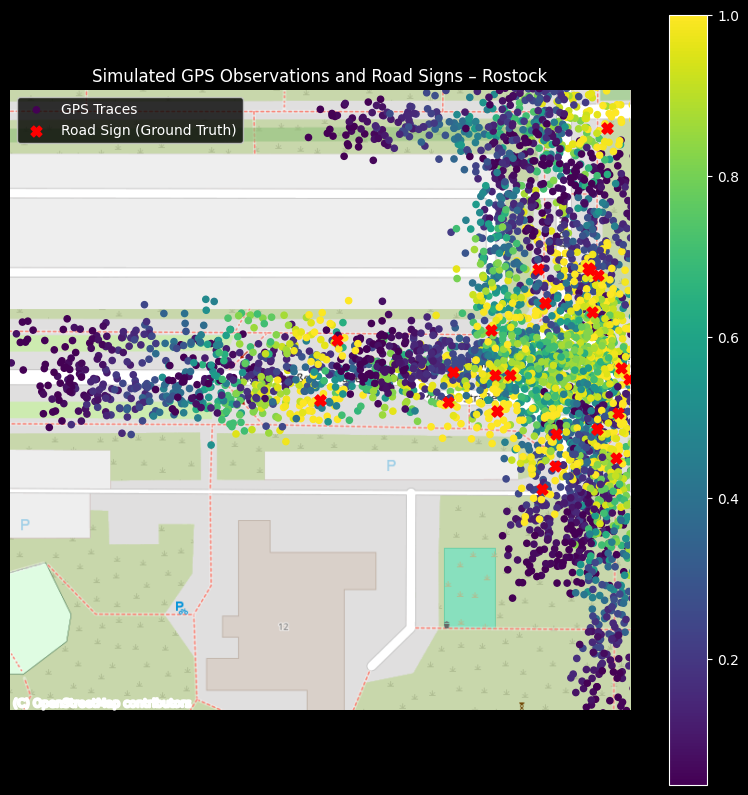

In [7]:
import geopandas
import matplotlib.pyplot as plt
import contextily as ctx

# let's plot the traces now so what we understand our simulated input dataset better
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df["gps_traces_lon"], df["gps_traces_lat"]), crs="EPSG:4326"
)

# we also want the ground truth - the real road sign positions
df_signs = input_df[["uuid", "latitude", "longitude"]].drop_duplicates()

gdf_signs = geopandas.GeoDataFrame(
    df_signs,
    geometry=geopandas.points_from_xy(df_signs["longitude"], df_signs["latitude"]),
    crs="EPSG:4326"
)

plot_geoframes("Simulated GPS Observations and Road Signs – Rostock", gdf_signs, {"GPS Traces": (gdf, "viridis")})

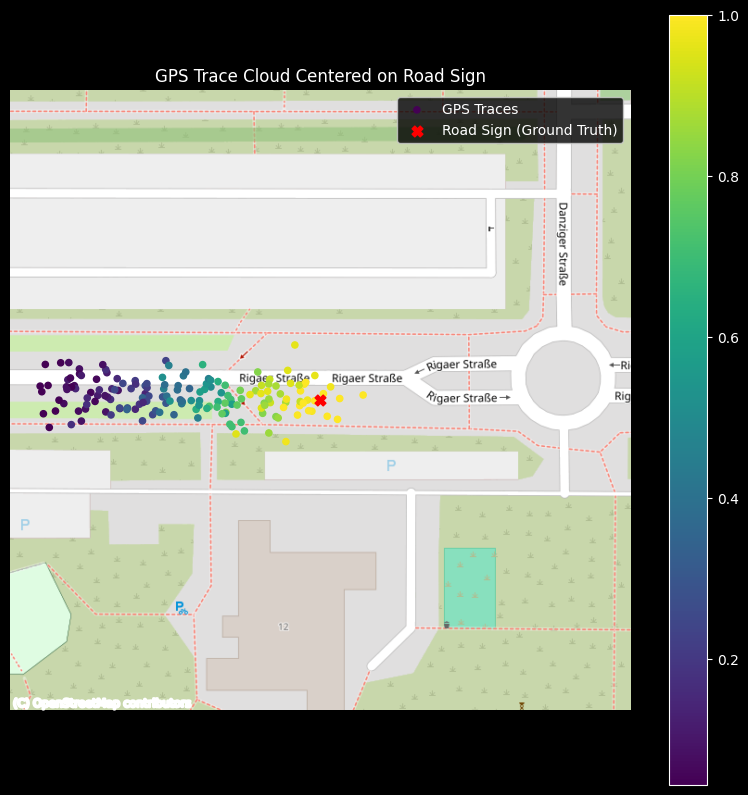

In [8]:
# let's focus on a single road sign now
obs_sub = gdf[gdf["uuid"] == sample_uuid]
sign_sub = gdf_signs[gdf_signs["uuid"] == sample_uuid]

plot_geoframes("GPS Trace Cloud Centered on Road Sign", sign_sub, {"GPS Traces": (obs_sub, "viridis")})

In [9]:
from sign_locator.sign_locator import SignLocator

# lets start our ETL and process the traces to locate the road signs correctly
sign_locator = SignLocator()
signs_df = sign_locator.extract_traces(df)
gdf_points_simple, gdf_tiles = sign_locator.calculate_sign_locations(signs_df, center_calc="simple")

Iteration 0: 1102507 points
Iteration 1: 40359 points
Iteration 2: 17885 points
Iteration 3: 17861 points
Converged after 4 iterations


In [10]:
gdf_points_dbscan, _ = sign_locator.calculate_sign_locations(signs_df, center_calc="DBSCAN")

In [11]:
# lets start our ETL and process the traces to locate the road signs correctly
gdf_points_kmeans, _ = sign_locator.calculate_sign_locations(signs_df, center_calc="k-means")

/var/folders/yw/mm7w_1cd13b427vkxt5t2x_00000gp/T/ipykernel_55817/2227678580.py:55: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


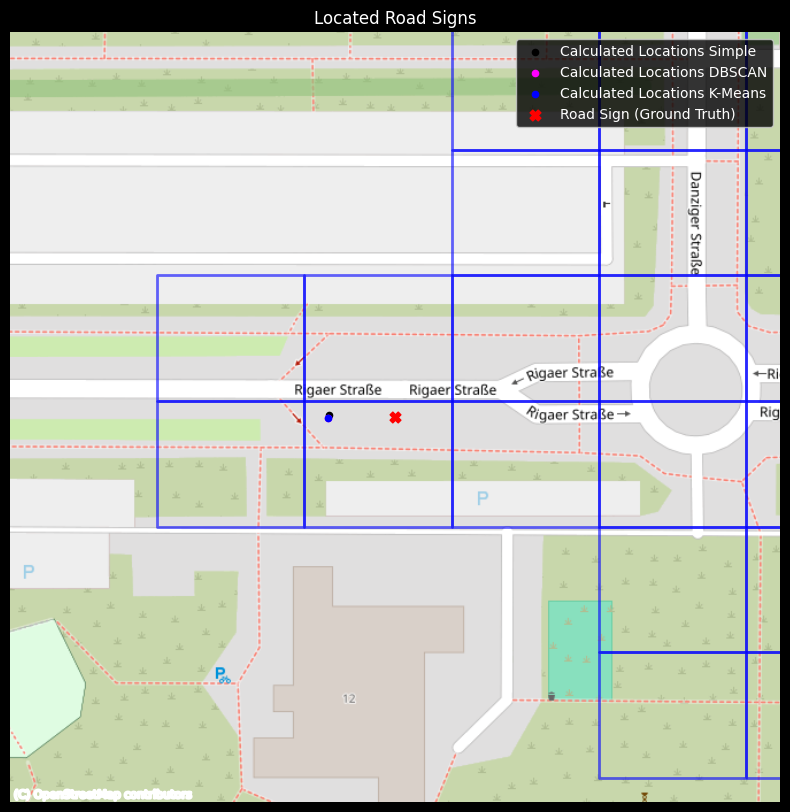

In [12]:
# let's focus on a single road sign now
sign_sub = gdf_signs[gdf_signs["uuid"] == sample_uuid]

traces_dict = {
    "Calculated Locations Simple": (gdf_points_simple[gdf_points_simple["uuid"] == sample_uuid], "gray"),
    "Calculated Locations DBSCAN": (gdf_points_dbscan[gdf_points_dbscan["uuid"] == sample_uuid], "spring"),
    "Calculated Locations K-Means": (gdf_points_kmeans[gdf_points_kmeans["uuid"] == sample_uuid], "winter"),
}

plot_geoframes("Located Road Signs", sign_sub, traces_dict, gdf_tiles)

In [13]:
val_simple = validate_results(gdf_points_simple, gdf_signs, "Simple")
val_dbscan = validate_results(gdf_points_dbscan, gdf_signs, "DBSCAN")
val_kmeans = validate_results(gdf_points_kmeans, gdf_signs, "k-Means")

validation_all = pd.concat([val_simple, val_dbscan, val_kmeans], ignore_index=True)

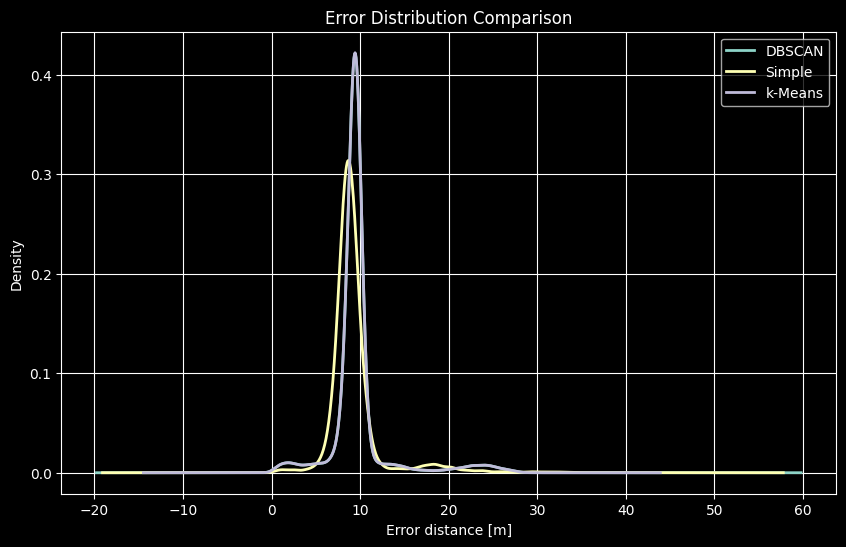

In [14]:
plot_error_distributions(validation_all)

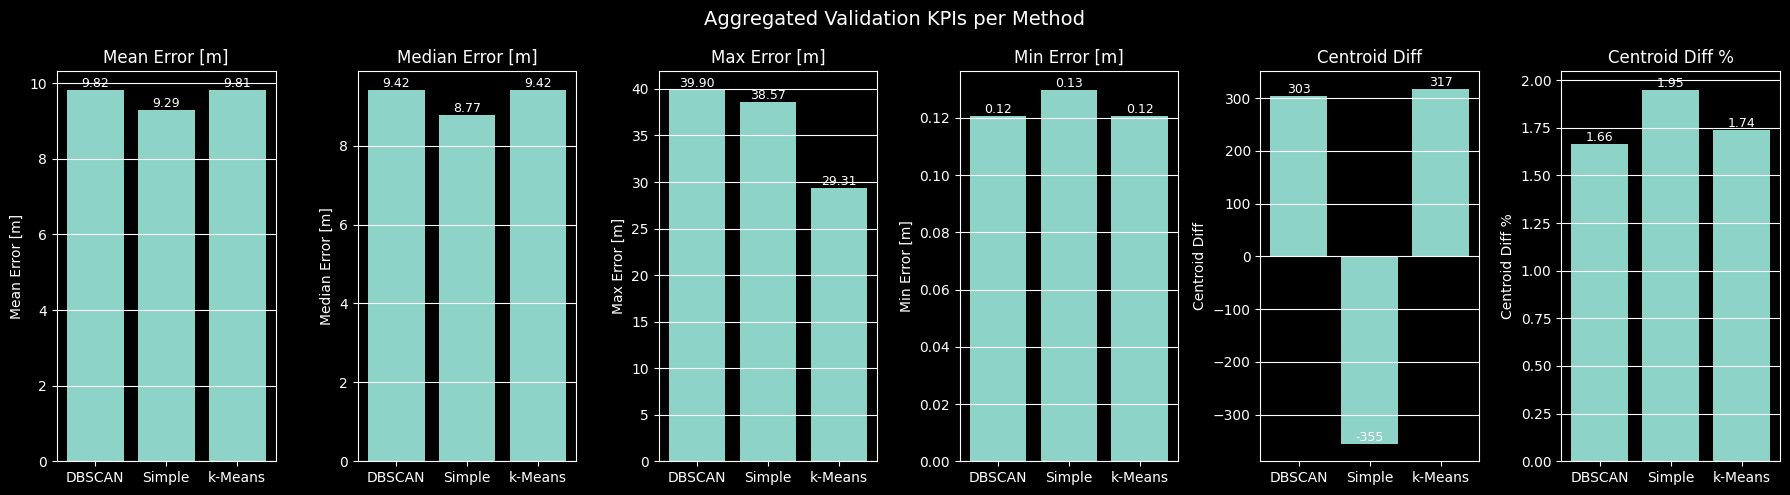

In [19]:
plot_aggregated_kpis(validation_all, gdf_signs)